In [22]:
import os
import glob
import importlib

import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

import analyze2p.plotting as pplot
# import analyze2p.receptive_fields.utils as rfutils
import analyze2p.gratings.utils as gutils 
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.extraction.traces as traceutils
import analyze2p.gratings.bootstrap_osi as osi

In [4]:
%matplotlib notebook

In [5]:
def temporal_downsample(trace, windowsz):
    tmp1=np.concatenate((np.ones(windowsz)*trace[0], trace, np.ones(windowsz)*trace[-1]),0)
    tmp2=np.convolve(tmp1, np.ones(windowsz)/windowsz, 'same')
    tmp2=tmp2[windowsz:-windowsz]
    return tmp2

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


# Select source

In [8]:
responsive_test='ROC'
# -----------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
n_bootstrap_iters=500

ori_fit_desc = gutils.get_fit_desc(response_type=response_type, responsive_test=responsive_test, 
                            responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500


In [9]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
metad = sdata[sdata.experiment.isin(['gratings'])].copy()
dkeys = [(va, dk) for (va, dk), g in metad.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
            if (va, dk) in dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


,animalid,session,fovnum
visual_area,,,
Li,15,15,15
Lm,9,9,9
V1,9,9,9


# Output dir

In [11]:
base_dir = os.path.join(aggregate_dir, 'gratings-tuning', 
                       '%s-%s' % (traceid, ori_fit_desc))
dst_dir = os.path.join(base_dir, 'examples', 'traces')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'responsive_examples')
print(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/examples/traces
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES/responsive_examples


# Load all fits

In [195]:
importlib.reload(gutils)

<module 'analyze2p.gratings.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py'>

In [12]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)

In [196]:
gdata = gutils.assign_theta_bin(gdata)

0
45
90
135
180
225
270
315


# Example datasets

In [109]:
# def clean_axes(axes):
#     for ai, ax in enumerate(axes.flat):
#         ax.tick_params(which='both', axis='both', length=0)
#         if ai == 0:
#             ax.set_yticks([0, ymax])
#             ax.set_yticklabels(['', ''])
#             ax.set_ylabel('%.2f dF/F' % ymax, fontsize=fontsize)
#             sns.despine(trim=True, ax=ax, offset=4, bottom=True)
#             ax.set_xticklabels([])
#         else:
#             sns.despine(trim=True, ax=ax, offset=4, left=True, bottom=True)
#             ax.set_xticklabels([])
#     return

# def add_stimulus_patch(fig, col_values):
#     n_conds = len(col_values)
#     for ci in range(len(col_values)):
#         ax=axes[n_conds-1, ci]
#         rect = pl.Rectangle((0,0), width=1, 
#                     height=(n_conds-2)+fig.subplotpars.wspace,
#                     transform=ax.get_xaxis_transform(), clip_on=False, zorder=0,
#                     edgecolor="none", facecolor="gray", alpha=0.2, linewidth=0)
#         ax.add_patch(rect)
#     return

In [ ]:
fit_params=['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']     

In [56]:
windowsz = 9
smooth_traces = True
plot_trials = True
ymax = 0.5
min_val, max_val = 0, 0

col_values = sorted(sdf['ori'].unique())

<IPython.core.display.Javascript object>


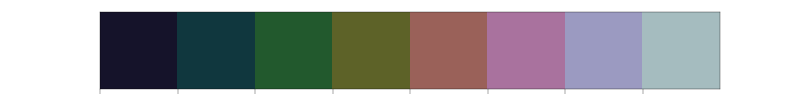

In [449]:
# colors
tested_thetas = sorted(sdf['ori'].unique())
cmap='cubehelix'
cmap_d = pplot.darken_cmap(colormap=cmap, alpha=0.8)
    
#ori_colors = sns.color_palette(ori_colormap, n_colors=len(tested_thetas))
sns.palplot(sns.color_palette(cmap_d, n_colors=len(tested_thetas)))
trace_color = 'k'

In [334]:
cfg_values

[(0.1, 30.0, 10),
 (0.1, 30.0, 20),
 (0.1, 200.0, 10),
 (0.1, 200.0, 20),
 (0.5, 30.0, 10),
 (0.5, 30.0, 20),
 (0.5, 200.0, 10),
 (0.5, 200.0, 20)]

# Select 1 dataset

In [602]:
va='Lm'
gdata[(gdata.visual_area==va) 
      & ~(gdata.datakey.isin(['20190517_JC083_fov1', '20190513_JC078_fov1', '20190512_JC083_fov1']))
     & (gdata['gof']>0.66)].sort_values(by=['gof', 'response_pref', 'datakey'], ascending=False)\
[['visual_area', 'datakey', 'cell', 'response_pref', 'response_null', 'gof', 'sigma']].iloc[0:20]

,visual_area,datakey,cell,response_pref,response_null,gof,sigma
2313,Lm,20190627_JC091_fov1,225,0.396424,0.342591,0.913454,31.193973
1775,Lm,20190525_JC084_fov1,152,0.384398,0.359160,0.906640,27.734830
2209,Lm,20190618_JC097_fov1,101,0.372358,0.326706,0.894932,30.022451
1885,Lm,20190603_JC080_fov1,30,0.326691,0.247634,0.876814,26.173382
2314,Lm,20190627_JC091_fov1,225,0.328468,0.275281,0.857403,33.901584
1703,Lm,20190525_JC084_fov1,96,0.151986,0.082116,0.853582,30.815058
1952,Lm,20190603_JC080_fov1,99,0.165963,0.139554,0.853501,22.799845
1846,Lm,20190525_JC084_fov1,231,0.355089,0.265274,0.852505,23.356733
1754,Lm,20190525_JC084_fov1,140,0.189336,0.164073,0.849311,22.651483
2066,Lm,20190603_JC080_fov1,223,0.145379,0.106903,0.847799,22.503289


In [640]:
va='Li'
dk = '20190614_JC091_fov1'
rid = 304 #235 #304

# va='Lm'
# dk = '20190525_JC084_fov1'
# rid=152

# va='Lm'
# dk = '20190627_JC091_fov1'
# rid=225

# va='V1'
# dk = '20190617_JC097_fov1'
# rid=155 #280

curr_data_id = '%s\n%s_%s' % (data_id, dk, va) #

In [641]:
# Current dataset fits
fits = gdata[(gdata.visual_area==va) & (gdata.datakey==dk)].copy()
# Fit params
fitresults, fitparams = gutils.load_tuning_results(dk, 
                                fit_desc=ori_fit_desc, traceid=traceid)
g = CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]
g.shape
# Get OSI results
rois_ = g['cell'].unique()
boot_ = dict((k, v) for k, v in fitresults.items() if k in rois_)

# Colors
cfg_values = sorted([tuple(c) for c in fitparams['nonori_configs']])
print(col_values)
print(cfg_values)
n_conds = len(cfg_values)
cfg_colors = sns.color_palette(palette=cmap_d, n_colors=len(cfg_values))
cfg_cdict = dict((k, v) for k, v in zip(cfg_values, cfg_colors))

[0, 45, 90, 135, 180, 225, 270, 315]
[(0.1, 30.0, 10), (0.1, 30.0, 20), (0.1, 200.0, 10), (0.1, 200.0, 20), (0.5, 30.0, 10), (0.5, 30.0, 20), (0.5, 200.0, 10), (0.5, 200.0, 20)]


In [642]:
fits.shape

(174, 24)

In [643]:
### Load traces
data_fpath = traceutils.get_data_fpath(dk, experiment_name='gratings')
print(data_fpath)
raw_traces, labels, sdf, run_info = traceutils.load_dataset(data_fpath, 
                                                    trace_type='corrected')
dff_traces, trialmetrics = aggr.process_traces(raw_traces, labels, 
                        trace_type='dff', 
                        response_type='dff', trial_epoch='stimulus')

/n/coxfs01/2p-data/JC091/20190614/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_7dabd5_traces001_55cc1f_traces001_acb6f5_traces001_02c540/data_arrays/corrected.npz
--- processed traces: dff


In [644]:
# rid = 155 #352

In [645]:
# Tuning curves for selected cells
d_list=[]
c_list=[]
currfits = fits[fits['cell']==rid][['sf', 'size', 'speed']]
for i, v in currfits.iterrows():
    ckey = tuple(v[['sf', 'size', 'speed']])
    cfgs_ = sorted([g for g, (sf, sz, sp) in \
                    sdf[['sf', 'size', 'speed']].iterrows() \
                    if tuple([sf, sz, sp])==ckey])
    meanr = trialmetrics[trialmetrics.config.isin(cfgs_)][[rid, 'config']]\
                    .groupby('config').mean()
    meanr.index = sdf.loc[meanr.index.tolist()]['ori'].values
    meanr.columns = [tuple(v.values)]
    d_list.append(meanr)
    #c_list.append('_'.join([str(i) for i in v.values]))
tuning_curves = pd.concat(d_list, axis=1, ignore_index=False)

<IPython.core.display.Javascript object>


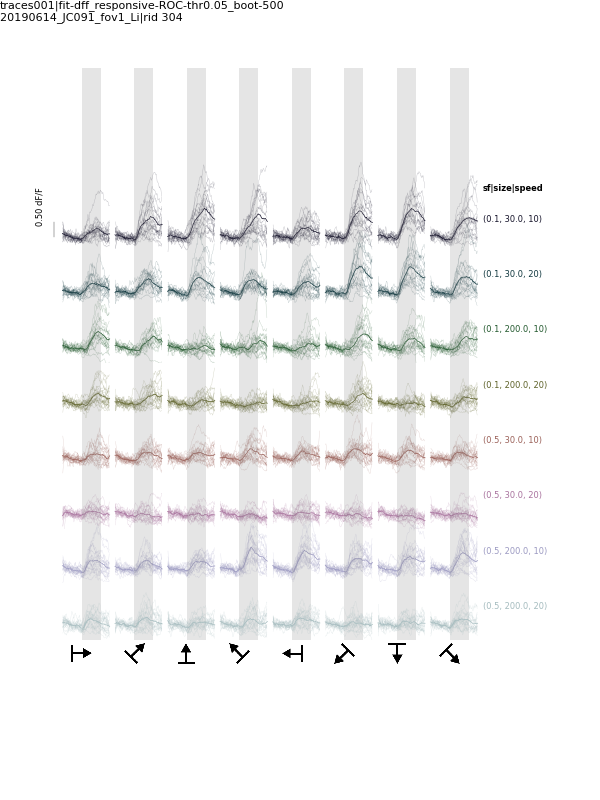

0 (0.1, 30.0, 10)
1 (0.1, 30.0, 20)
2 (0.1, 200.0, 10)
3 (0.1, 200.0, 20)
4 (0.5, 30.0, 10)
5 (0.5, 30.0, 20)
6 (0.5, 200.0, 10)
7 (0.5, 200.0, 20)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/examples/traces Li_20190614_JC091_fov1_rid304_traces


In [646]:
nr = len(cfg_values)
nc = len(col_values)
fontsize=6
n_conds = len(cfg_values)

fig, axes = pl.subplots(nr, nc, 
                    figsize=(6,8), sharex=True, sharey=True)
fig.patch.set(alpha=1)
for ci, (condkey, col) in enumerate(zip(cfg_values, cfg_colors)):
    currcfgs = boot_[rid][condkey]['stimulus_configs']
    currlabels = labels[labels['config'].isin(currcfgs)]
    si = cfg_values.index(condkey)
    print(si, condkey)
    # Plot all trial traces
    for cf, (cfg, g) in enumerate(currlabels.groupby(['config'])):
        curr_ori = sdf['ori'][cfg] #.copy()
        plot_ix = col_values.index(curr_ori)
        ax = axes[ci, plot_ix]
        ax.patch.set(alpha=0)
        for trial, tdf in g.groupby(['trial']):
            tsec = tdf['tsec'].values
            tvals = dff_traces[rid][tdf.index].values
            st = temporal_downsample(tsec, windowsz) if smooth_traces else tsec
            sm = temporal_downsample(tvals, windowsz) if smooth_traces else tvals
            ax.plot(st, sm, color=col, alpha=0.3, lw=0.25)
        meantrace = np.nanmean(np.array([dff_traces[rid][gg.index] \
                        for trial, gg in g.groupby(['trial'])]), axis=0)
        sm = temporal_downsample(meantrace, windowsz) if smooth_traces else meantrace
        ax.plot(tsec, sm, color=col, alpha=1, lw=0.5)
        if plot_ix == 7:
            ax.text(1.75, 0.5, condkey, color=col, fontsize=6)
            if ci==0:
                ax.text(1.75, 1.5, 'sf|size|speed', color='k', 
                        fontweight='bold', fontsize=6)
        ax.set_ylim([-0.5, 2.5])
clean_axes(axes)
# Add rectangle for stimulus
add_stimulus_patch(fig, col_values)
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.1, right=0.8, 
                   hspace=-.4, wspace=0.01)

for ori_ix, ori_val in enumerate(tested_thetas):
    ax=axes[7, ori_ix]
    #ax.set_title(ori_val)
    pplot.replace_ori_labels([ori_val],bin_centers=[0], ax=ax, xybox=(0, 0), 
                             yloc=ax.get_ylim()[0]*.3, 
                             zoom=0.2, polar=False)

#save
pplot.label_figure(fig, '%s|rid %i' % (curr_data_id, rid))
figname='%s_%s_rid%i_traces' % ( va, dk, rid) 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [647]:
fits[(fits['cell']==rid)][['r2', 'gof', 'sf', 'size', 'speed']]


,r2,gof,sf,size,speed
724,0.892349,0.662317,0.1,30.0,10.0
725,0.676541,0.250608,0.1,200.0,20.0
726,0.649331,0.297211,0.5,30.0,10.0
727,0.822681,0.586615,0.5,30.0,20.0
728,0.552773,0.068352,0.5,200.0,20.0


<IPython.core.display.Javascript object>


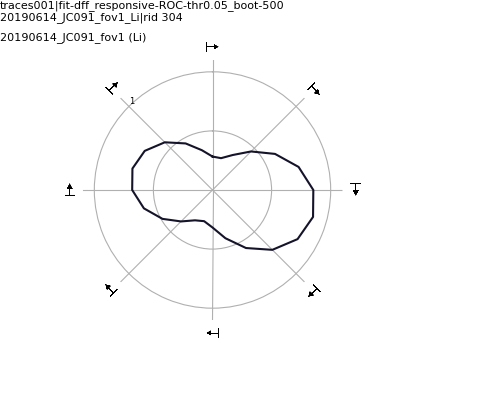

(0.1, 30.0, 10.0)
/n/coxfs01/julianarhee/aggregate-visual-areas/gratings-tuning/traces001-fit-dff_responsive-ROC-thr0.05_boot-500/examples/traces Li_20190614_JC091_fov1_rid304_polar


In [648]:
%matplotlib notebook
plot_data=True
plot_fit=True

fig, ax = pl.subplots(subplot_kw={'projection': 'polar'})
curr_fits = fits[(fits['cell']==rid) & (fits['gof']>=0.6)].copy()
plot_polar_axis(ax, curr_fits, tuning_curves, cfg_cdict, 
                plot_fit=True, plot_data=False, scale=True)
pl.subplots_adjust(left=0.05, right=0.8, bottom=0.2, top=0.85)
fig.text(0.0, 0.9, '%s (%s)' % (dk, va), fontsize=8)
#save
pplot.label_figure(fig, '%s|rid %i' % (curr_data_id, rid))
figname='%s_%s_rid%i_polar' % ( va, dk, rid) 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [649]:
def plot_polar_axis(ax, curr_fits, tuning_curves, cfg_cdict, scale=False,
                   plot_data=True, plot_fit=True):
    tested_thetas = np.arange(0, 360, 45)
    fit_params=['response_pref', 'response_null', 'theta_pref', 'sigma', 
                'response_offset']     
    thetas = osi.interp_values(tested_thetas, n_intervals=3, wrap_value=360)
    if scale:
        tuning_curves_tmp = tuning_curves.copy()
        maxv = tuning_curves.max().max()
        tuning_curves = tuning_curves_tmp.divide(maxv)
        maxv = curr_fits['response_pref'].max() #fit_params
        curr_fits['response_pref'] = curr_fits['response_pref'].values/maxv
        curr_fits['response_null'] = curr_fits['response_null'].values/maxv

    for i, v in curr_fits.iterrows():
        cpopt = tuple(v[fit_params].values)       
        fitv = osi.double_gaussian( thetas, *cpopt)  
        pref_v = float(v['tested_theta'])
        cfg_key = tuple(v[['sf', 'size', 'speed']])
        print(cfg_key)
        meanr = tuning_curves[cfg_key].copy().values
        if meanr.min()<0:
            meanr -= meanr.min()

        truv = np.array(osi.interp_values(meanr, n_intervals=3, wrap_value=meanr[-1]))
        if plot_data:
            _, ax = osi.polar_plot_roi(thetas, truv, curr_sems=None, 
                    response_type='dff', fig=ax.figure, ax=ax, 
                    color=cfg_cdict[cfg_key], linestyle=':')
        if plot_fit:
            _, ax = osi.polar_plot_roi(thetas, fitv, curr_sems=None, 
                    response_type='dff', fig=ax.figure, ax=ax, 
                    color=cfg_cdict[cfg_key])
    if scale:
        ylim = 1.1
        ytick_lim = 1
        ax.set_yticks([0.5, 1])
    else:
        ylim = ax.get_ylim()[-1].round(2)
        ytick_lim=ylim
    pplot.polar_ticks_gratings(ax, ylim=ylim, ytick_lim=ytick_lim, n_yticks=3)   
        #     ax.set_ylim([0, 0.7])
    return ax

In [517]:
tuning_curves

,"(0.1, 30.0, 10.0)","(0.1, 30.0, 20.0)","(0.1, 200.0, 20.0)","(0.5, 30.0, 10.0)","(0.5, 30.0, 20.0)","(0.5, 200.0, 10.0)","(0.5, 200.0, 20.0)"
0,0.000000,0.216157,0.003489,0.015798,0.196318,-0.025998,-0.005934
45,0.346204,0.522291,0.018931,0.019989,0.022524,-0.033230,0.033656
90,1.000000,0.890255,0.042705,0.076208,1.000000,-0.035054,0.005003
135,0.165200,0.216908,0.021019,0.005516,0.223743,-0.025136,-0.016610
180,0.098228,0.052023,0.007204,-0.049209,0.020428,0.003770,0.003869
225,0.414791,0.480551,0.059458,0.040460,0.268279,-0.001540,0.005615
270,0.989640,1.000000,0.063311,0.048043,0.865713,0.025577,0.013897
315,0.240295,0.241922,0.014932,0.011860,0.350487,-0.023939,-0.020045
